# Time Series Analysis and Univariate ARIMA Models

In [23]:
import os
import sys
import warnings
from datetime import date
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, acf, plot_pacf, pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
import statsmodels.api as sm
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

import quandl
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [24]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

## Download Series

Load monthly industrial production and daily NASDAQ stock market index:

In [4]:
industrial_production = web.DataReader('IPGMFN', 'fred', '1988', '2017-12').squeeze().dropna()
nasdaq = web.DataReader('NASDAQCOM', 'fred', '1990', '2017-12-31').squeeze().dropna()

## Additive Decomposition

In [5]:
components = tsa.seasonal_decompose(industrial_production, model='additive')

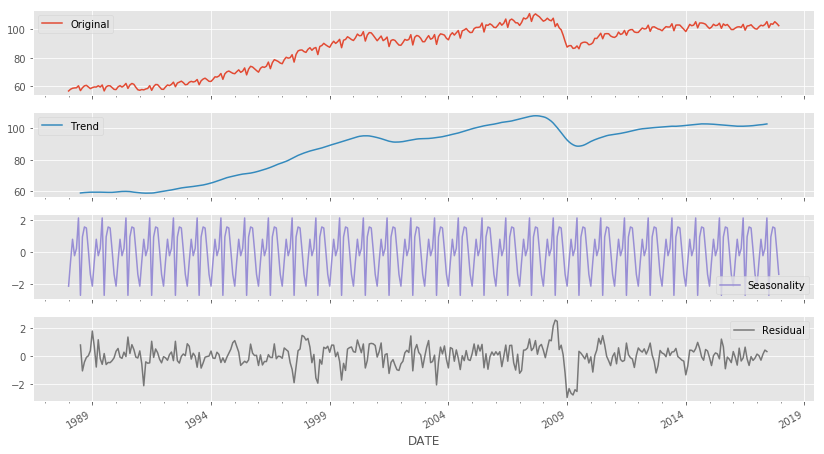

In [6]:
ts = (industrial_production.to_frame('Original')
      .assign(Trend=components.trend)
      .assign(Seasonality=components.seasonal)
      .assign(Residual=components.resid))
ts.plot(subplots=True, figsize=(14, 8));

## Time Series Stationarity

### Log Transformation

Double check fo zero values

In [7]:
(nasdaq == 0).any(), (industrial_production==0).any()

(False, False)

In [13]:
nasdaq_log = np.log(nasdaq)
industrial_production_log = np.log(industrial_production)

### Differencing

Differencing of log series produces instantaneous returns.

In [14]:
nasdaq_log_diff = nasdaq_log.diff().dropna()

# seasonal differencing => yoy instantanteous returns
industrial_production_log_diff = industrial_production_log.diff(12).dropna()

### Plot Series

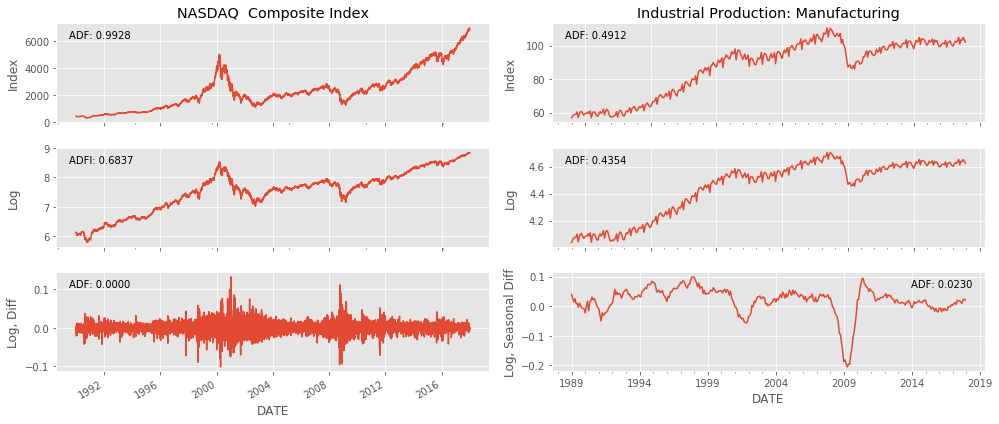

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,6))

nasdaq.plot(ax=axes[0][0], title='NASDAQ  Composite Index')
axes[0][0].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(nasdaq.dropna())[1]:.4f}', transform=axes[0][0].transAxes)
axes[0][0].set_ylabel('Index')

nasdaq_log.plot(ax=axes[1][0], sharex=axes[0][0])
axes[1][0].text(x=.03, y=.85, s=f'ADFl: {tsa.adfuller(nasdaq_log.dropna())[1]:.4f}', transform=axes[1][0].transAxes)
axes[1][0].set_ylabel('Log')

nasdaq_log_diff.plot(ax=axes[2][0], sharex=axes[0][0])
axes[2][0].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(nasdaq_log_diff.dropna())[1]:.4f}', transform=axes[2][0].transAxes)
axes[2][0].set_ylabel('Log, Diff')

industrial_production.plot(ax=axes[0][1], title='Industrial Production: Manufacturing')
axes[0][1].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(industrial_production)[1]:.4f}', transform=axes[0][1].transAxes)
axes[0][1].set_ylabel('Index')

industrial_production_log.plot(ax=axes[1][1], sharex=axes[0][1])
axes[1][1].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(industrial_production_log.dropna())[1]:.4f}', transform=axes[1][1].transAxes)
axes[1][1].set_ylabel('Log')

industrial_production_log_diff.plot(ax=axes[2][1], sharex=axes[0][1])
axes[2][1].text(x=.83, y=.85, s=f'ADF: {tsa.adfuller(industrial_production_log_diff.dropna())[1]:.4f}', transform=axes[2][1].transAxes)
axes[2][1].set_ylabel('Log, Seasonal Diff')
fig.tight_layout()
fig.align_ylabels(axes);

## Correlogram

### NASDAQ (log, diff)

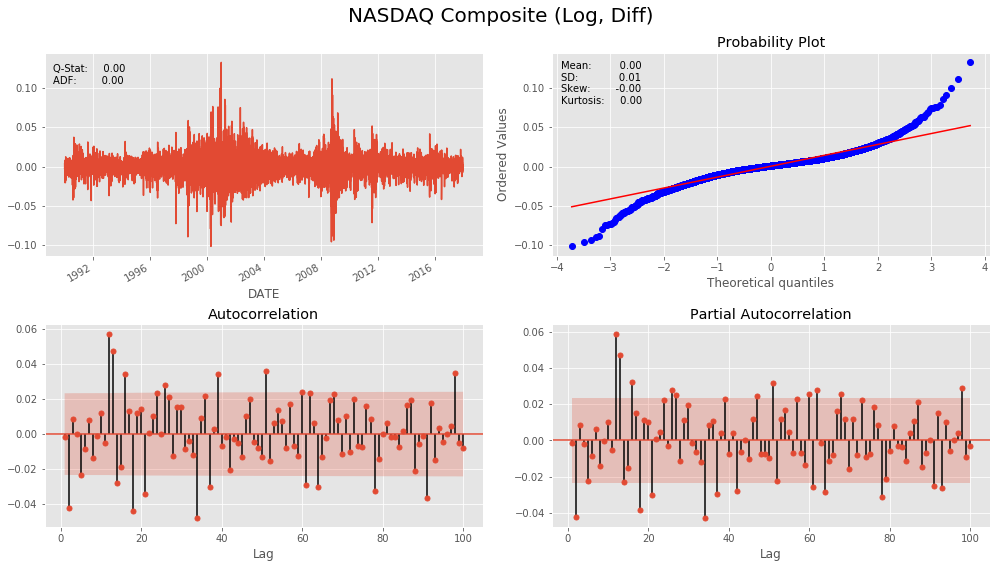

In [25]:
plot_correlogram(nasdaq_log_diff, lags=100, title='NASDAQ Composite (Log, Diff)')

### Industrial Production (log, seasonl diff)

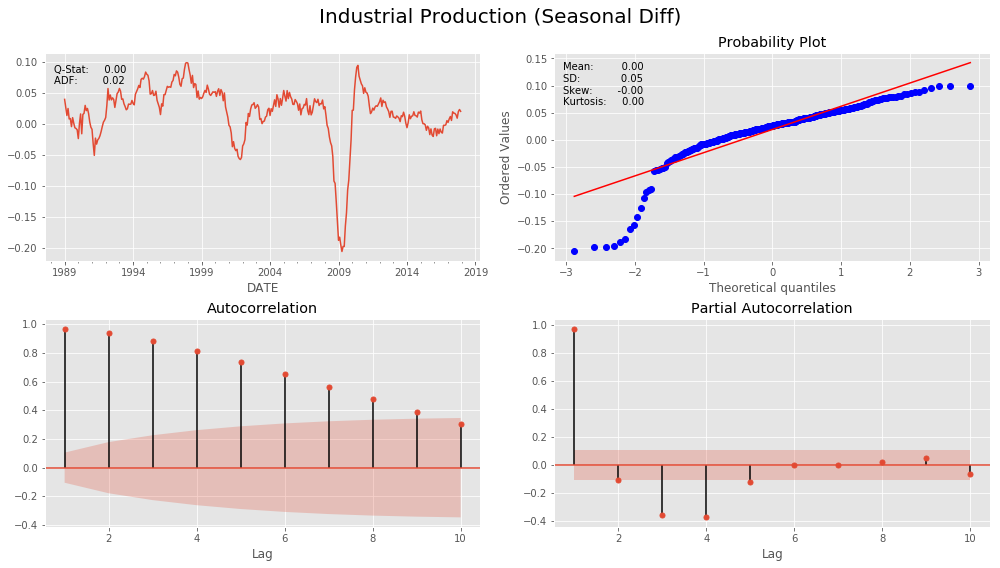

In [26]:
plot_correlogram(industrial_production_log_diff, title='Industrial Production (Seasonal Diff)')

## Autoregressive (AR) Model

Fit the unconditional maximum likelihood of an AR(p) process.

### ARMA vs ARIMA

The ARMA model of the undifferenced series produces the same result as the ARIMA model of the differenced series.

In [27]:
model1 = tsa.ARMA(endog=nasdaq_log_diff, order=(2,2)).fit()
model2 = tsa.ARIMA(endog=nasdaq_log, order=(2,1,2)).fit()

In [28]:
model1.params.sort_index() == model2.params.sort_index().values

ar.L1.NASDAQCOM    True
ar.L2.NASDAQCOM    True
const              True
ma.L1.NASDAQCOM    True
ma.L2.NASDAQCOM    True
dtype: bool

### Seasonal differencing vs SARIMAX

Seasonal differencing has same effect as using SARIMAX w seasonal order (0,1,0,12).

In [29]:
model1 = tsa.statespace.SARIMAX(industrial_production_log, order=(2,0,2), seasonal_order=(0,1,0,12)).fit()
model2 = tsa.statespace.SARIMAX(industrial_production_log_diff, order=(2,0,2), seasonal_order=(0,0,0,12)).fit()

In [30]:
model1.params.to_frame('SARIMAX').join(model2.params.to_frame('diff'))

,SARIMAX,diff
ar.L1,1.770083,1.801082
ar.L2,-0.792145,-0.823738
ma.L1,-0.863548,-0.893217
ma.L2,0.349370,0.341511
sigma2,0.000101,0.000101


## Finding the optimal ARMA lags

In [31]:
train_size = 120
test_results = {}
y_true = industrial_production_log_diff.iloc[train_size:]
for p in range(5):
    for q in range(5):
        aic, bic = [], []
        if p == 0 and q == 0:
            continue
        print(p, q)
        convergence_error = stationarity_error = 0
        y_pred = []
        for T in range(train_size, len(industrial_production_log_diff)):
            train_set = industrial_production_log_diff.iloc[T-train_size:T]
            try:
                model = tsa.ARMA(endog=train_set, order=(p, q)).fit()
            except LinAlgError:
                convergence_error += 1
            except ValueError:
                stationarity_error += 1

            forecast, _, _ = model.forecast(steps=1)
            y_pred.append(forecast[0])
            aic.append(model.aic)
            bic.append(model.bic)

        result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
                  .replace(np.inf, np.nan)
                  .dropna())

        rmse = np.sqrt(mean_squared_error(
            y_true=result.y_true, y_pred=result.y_pred))

        test_results[(p, q)] = [rmse,
                                np.mean(aic),
                                np.mean(bic),
                                convergence_error,
                                stationarity_error]

0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4


In [32]:
eval = pd.DataFrame(test_results).T
eval.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
eval.index.names = ['p', 'q']
eval.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24 entries, (0, 1) to (4, 4)
Data columns (total 5 columns):
RMSE            24 non-null float64
AIC             18 non-null float64
BIC             18 non-null float64
convergence     24 non-null float64
stationarity    24 non-null float64
dtypes: float64(5)
memory usage: 1.2 KB


In [33]:
with pd.HDFStore('arima.h5') as store:
    print(store.info())
#     store.put('arima_results/2', eval)

<class 'pandas.io.pytables.HDFStore'>
File path: arima.h5
Empty


In [34]:
eval.dropna()

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
0 1  0.030045 -531.210372 -522.847897          0.0           0.0
  2  0.105762 -599.045002 -587.895035          0.0         107.0
  3  0.031671 -650.211841 -636.274382          0.0          94.0
  4  0.018367 -681.768983 -665.044033          0.0          94.0
1 0  0.011511 -727.903454 -719.540979          0.0           0.0
  1  0.029544 -732.638499 -721.488532          0.0          16.0
  2  0.021875 -744.263554 -730.326095          0.0          10.0
  3  0.018265 -748.084977 -731.360026          0.0           8.0
  4  0.018223 -753.425943 -733.913501          0.0           8.0
2 0  0.012038 -734.683385 -723.533418          4.0           0.0
  2  0.013055 -758.807458 -742.082508          1.0           4.0
  3  0.014244 -760.529607 -741.017165          5.0           3.0
  4  0.038150 -759.659599 -737.359665          1.0          22.0
3 0  0.010553 -747.742465 -733.805006          3.0           0.0
  1  0.011736 -754.961491 -738.236540          3.0           4.0
4 0  0.010060 -759.111308 -742.386358          0.0           0.0
  1  0.010609 -759.622426 -740.109983          2.0           2.0
  2  0.016478 -759.849551 -737.549617          8.0           4.0

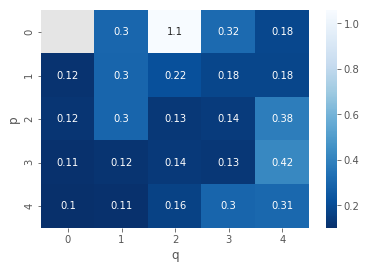

In [35]:
sns.heatmap(eval.RMSE.unstack().mul(10), fmt='.2', annot=True, cmap='Blues_r');

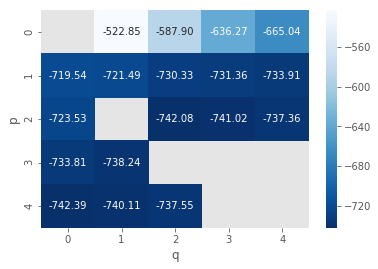

In [36]:
sns.heatmap(eval.BIC.unstack(), fmt='.2f', annot=True, cmap='Blues_r');

In [37]:
model = tsa.ARMA(endog=industrial_production_log_diff, order=(2, 2)).fit()
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                 IPGMFN   No. Observations:                  348
Model:                     ARMA(2, 2)   Log Likelihood                1107.977
Method:                       css-mle   S.D. of innovations              0.010
Date:                Wed, 31 Oct 2018   AIC                          -2203.954
Time:                        16:11:35   BIC                          -2180.841
Sample:                    01-01-1989   HQIC                         -2194.752
                         - 12-01-2017                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0203      0.008      2.394      0.017       0.004       0.037
ar.L1.IPGMFN     1.8206      0.052     34.924      0.000       1.718       1.923
ar.L2.IPGMFN    -0.8462      0.050    -16.77

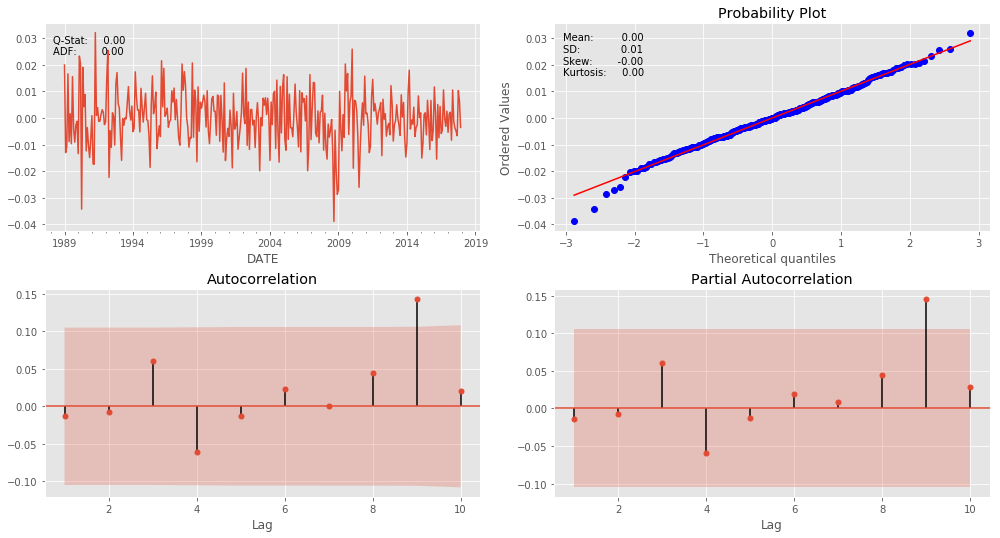

In [38]:
plot_correlogram(model.resid)

In [48]:
model = tsa.SARIMAX(endog=industrial_production_log_diff.dropna(),
                    order=(2, 0, 2),
                    seasonal_order=(1, 0, 1, 12)).fit(start_params=[0, 0, 0, 0, 0, 0, 1])
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             IPGMFN   No. Observations:                  348
Model:             SARIMAX(2, 0, 2)x(1, 0, 1, 12)   Log Likelihood                1128.813
Date:                            Wed, 31 Oct 2018   AIC                          -2243.626
Time:                                    16:28:47   BIC                          -2216.661
Sample:                                01-01-1989   HQIC                         -2232.891
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1105      0.643      0.172      0.864      -1.150       1.371
ar.L2          0.8825      0.640   

In [ ]:
plot_correlogram(model.resid)

In [ ]:
train_size = 120 # 10 years of training data
test_results = {}
test_set = industrial_production_log_diff.iloc[train_size:]

for p1 in range(4):
    for q1 in range(4):
        for p2 in range(3):
            for q2 in range(3):
                preds = test_set.copy().to_frame('y_true').assign(y_pred=np.nan)
                aic, bic = [], []
                if p1 == 0 and q1 == 0:
                    continue
                print(p1, q1, p2, q2)
                convergence_error = stationarity_error = 0
                y_pred = []
                for i, T in enumerate(range(train_size, len(industrial_production_log_diff))):
                    train_set = industrial_production_log_diff.iloc[T-train_size:T]
                    try:
                        model = tsa.SARIMAX(endog=train_set,
                                            order=(p1, 0, q1),
                                            seasonal_order=(p2, 0, q2, 12)).fit()
                    except LinAlgError:
                        convergence_error += 1
                    except ValueError:
                        stationarity_error += 1

                    preds.iloc[i, 1] = model.forecast(steps=1)[0]
                    aic.append(model.aic)
                    bic.append(model.bic)
 
                preds.dropna(inplace=True)
                mse = mean_squared_error(preds.y_true, preds.y_pred)
                test_results[(p1, q1, p2, q2)] = [np.sqrt(mse),
                                                  preds.y_true.sub(preds.y_pred).std(),
                                                  np.mean(aic),
                                                  np.std(aic),                                                  
                                                  np.mean(bic),
                                                  np.std(bic),                                                  
                                                  convergence_error,
                                                  stationarity_error]

In [ ]:
df = pd.DataFrame(test_results).T
df.columns = ['RMSE', 'RMSE_std', 'AIC', 'AIC_std', 'BIC', 'BIC_std', 'convergence', 'stationarity']
df['CV'] = df.RMSE_std.div(df.RMSE)
df.index.names = ['p1', 'q1', 'p2', 'q2']
df.info()

In [ ]:
with pd.HDFStore('results/arima.h5') as store:
    store.put('arima_results/3', df)
    print(store.info())

In [51]:
with pd.HDFStore('results/arima.h5') as store:
    df = store.get('arima_results/3')

In [52]:
df.sort_values('RMSE').head(10)

RMSE  RMSE_std         AIC    AIC_std         BIC    BIC_std  \
p1 q1 p2 q2                                                                     
2  3  1  0   0.009323  0.009335 -772.247023  20.106627 -752.734581  20.106627   
3  2  1  0   0.009467  0.009486 -768.844028  17.479101 -749.331586  17.479101   
2  2  1  0   0.009540  0.009559 -770.904835  17.162805 -754.179884  17.162805   
   3  0  0   0.009773  0.009790 -760.248885  23.627233 -743.523935  23.627233   
   2  0  0   0.009986  0.010005 -758.775827  20.636387 -744.838368  20.636387   
3  2  0  0   0.010066  0.010088 -757.467934  20.319519 -740.742984  20.319519   
   3  1  0   0.010490  0.010457 -770.605332  19.677360 -748.305398  19.677360   
      0  0   0.011543  0.011511 -758.301684  23.107904 -738.789241  23.107904   
   2  2  0   0.011688  0.011617 -767.646566  28.365300 -745.199922  28.261192   
2  3  2  0   0.011909  0.011857 -770.765094  30.125115 -748.318450  30.041888   

             convergence  stationarity        CV  
p1 q1 p2 q2                                       
2  3  1  0           2.0           1.0  1.001263  
3  2  1  0           1.0           1.0  1.001913  
2  2  1  0           0.0           2.0  1.002046  
   3  0  0           0.0           1.0  1.001768  
   2  0  0           0.0           2.0  1.001922  
3  2  0  0           2.0           1.0  1.002172  
   3  1  0           2.0           6.0  0.996836  
      0  0           1.0           6.0  0.997194  
   2  2  0           2.0          13.0  0.993956  
2  3  2  0           1.0          13.0  0.995627

In [53]:
print(df[['RMSE', 'AIC', 'BIC']].sort_values('RMSE').head())

                 RMSE         AIC         BIC
p1 q1 p2 q2                                  
2  3  1  0   0.009323 -772.247023 -752.734581
3  2  1  0   0.009467 -768.844028 -749.331586
2  2  1  0   0.009540 -770.904835 -754.179884
   3  0  0   0.009773 -760.248885 -743.523935
   2  0  0   0.009986 -758.775827 -744.838368


In [54]:
df[['RMSE', 'AIC', 'BIC']].corr('spearman')

,RMSE,AIC,BIC
RMSE,1.000000,0.368545,0.417667
AIC,0.368545,1.000000,0.940401
BIC,0.417667,0.940401,1.000000


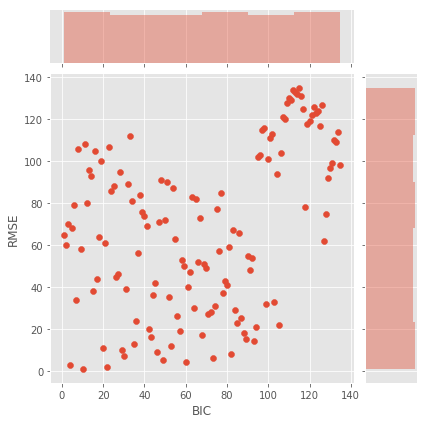

In [56]:
sns.jointplot(y='RMSE', x='BIC', data=df[['RMSE', 'BIC']].rank());

In [57]:
df[(df.RMSE<df.RMSE.quantile(.05))&(df.BIC<df.BIC.quantile(.1))]

RMSE  RMSE_std         AIC    AIC_std         BIC    BIC_std  \
p1 q1 p2 q2                                                                     
2  2  1  0   0.009540  0.009559 -770.904835  17.162805 -754.179884  17.162805   
   3  1  0   0.009323  0.009335 -772.247023  20.106627 -752.734581  20.106627   

             convergence  stationarity        CV  
p1 q1 p2 q2                                       
2  2  1  0           0.0           2.0  1.002046  
   3  1  0           2.0           1.0  1.001263

In [58]:
best_model = tsa.SARIMAX(endog=industrial_production_log_diff, order=(2, 0, 3),
                         seasonal_order=(1, 0, 0, 12)).fit()
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             IPGMFN   No. Observations:                  348
Model:             SARIMAX(2, 0, 3)x(1, 0, 0, 12)   Log Likelihood                1139.719
Date:                            Wed, 31 Oct 2018   AIC                          -2265.438
Time:                                    22:58:00   BIC                          -2238.472
Sample:                                01-01-1989   HQIC                         -2254.702
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4934      0.104     14.351      0.000       1.289       1.697
ar.L2         -0.5159      0.102   

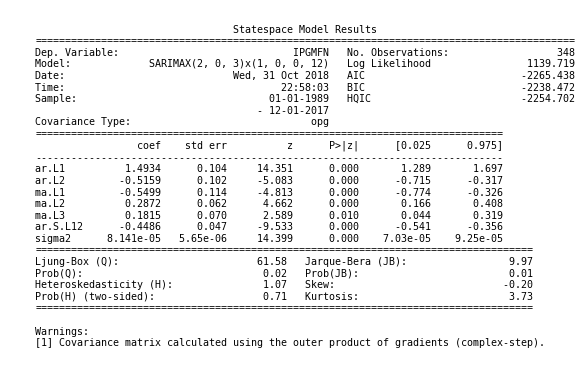

In [59]:
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(best_model.summary()), {'fontsize': 14}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.1)
plt.savefig('sarimax.png', bbox_inches='tight', dpi=300);

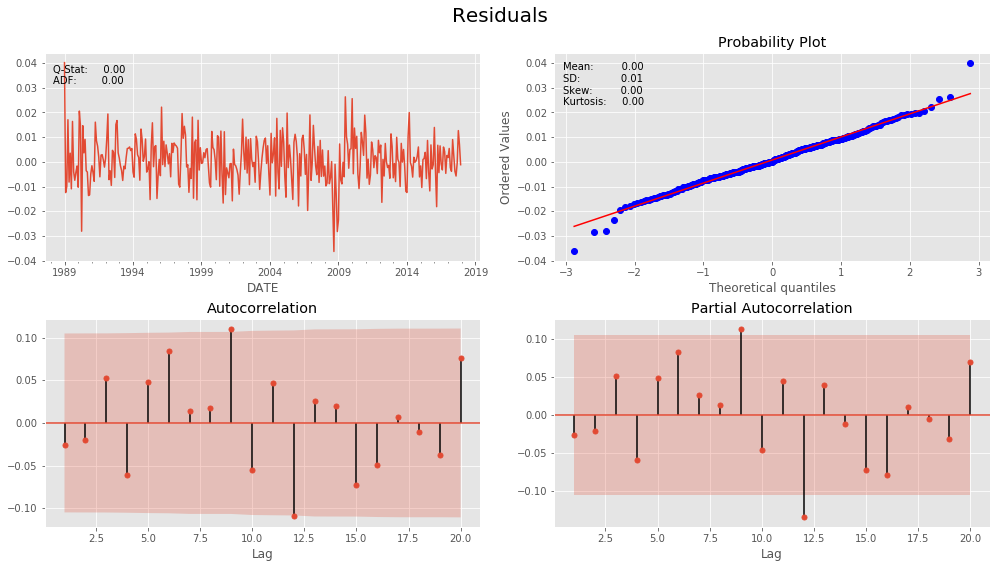

In [60]:
plot_correlogram(best_model.resid, lags=20, title='Residuals')